In [20]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionPipeline

# Load pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16
).to("cuda")

pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

# Constants
MSG_SIZE = 16
EMBED_REGION = slice(32, 48)
DEFAULT_ALPHA = 0.3  # We'll override this in later tests

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Message Recovery Accuracy: 55.66%


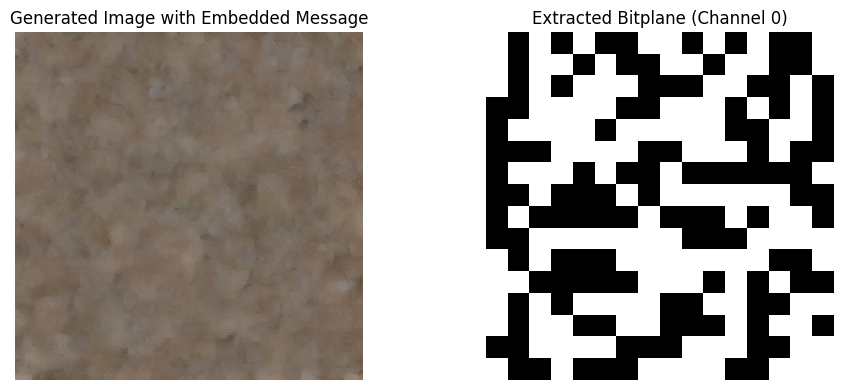

In [ ]:
def prepare_image_tensor(image: Image.Image):
    image = np.array(image).astype(np.float32) / 255.0
    image = (image - 0.5) * 2.0
    return torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to("cuda", dtype=torch.float16)

def encode_latents(image_tensor):
    return pipe.vae.encode(image_tensor).latent_dist.sample() * 0.18215

def decode_latents(latents):
    decoded = pipe.vae.decode(latents / 0.18215).sample
    decoded = (decoded / 2 + 0.5).clamp(0, 1)
    decoded = decoded.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
    return Image.fromarray((decoded * 255).astype(np.uint8))


In [ ]:
def dct_embed(latents, message, alpha=DEFAULT_ALPHA, channels=4):
    latents_np = latents.detach().cpu().float().numpy()
    message_np = message.detach().cpu().float().numpy()

    for i in range(channels):
        dct = cv2.dct(latents_np[0, i])
        dct[EMBED_REGION, EMBED_REGION] += alpha * message_np[0, i]
        latents_np[0, i] = cv2.idct(dct)

    latents_np = (latents_np - latents_np.mean()) / (latents_np.std() + 1e-8)
    return torch.tensor(latents_np, device=latents.device, dtype=latents.dtype) * 0.18215

def dct_extract(latents, threshold="mean", channels=4):
    latents_np = (latents.detach().cpu().float().numpy()) / 0.18215
    extracted = np.zeros((1, channels, MSG_SIZE, MSG_SIZE))

    for i in range(channels):
        dct = cv2.dct(latents_np[0, i])
        patch = dct[EMBED_REGION, EMBED_REGION]
        t = patch.mean() if threshold == "mean" else threshold
        extracted[0, i] = (patch > t).astype(int)

    return extracted


🔹 Generating Image Without Modification - Latents mean=-0.004113493021577597, std=0.9998632669448853


  0%|          | 0/50 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.manual_seed(42)
message = torch.randint(0, 2, (1, 4, MSG_SIZE, MSG_SIZE), device="cuda").float()
latents = torch.randn(1, 4, 64, 64, device="cuda", dtype=torch.float16)

stego_latents = dct_embed(latents, message)
stego_image = decode_latents(stego_latents)

# Re-encode and extract
image_tensor = prepare_image_tensor(stego_image)
recovered_latents = encode_latents(image_tensor)
extracted = dct_extract(recovered_latents)

# Accuracy
accuracy = 100 * (message.round().cpu().numpy() == extracted).mean()
print(f"Baseline Accuracy (alpha=0.3, 4 ch, mean threshold): {accuracy:.2f}%")

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(stego_image)
plt.title("Generated Image with Embedded Message")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(extracted[0, 0], cmap='gray')
plt.title("Extracted Bitplane (Channel 0)")
plt.axis("off")
plt.show()


In [ ]:
stego_latents = dct_embed(latents, message, alpha=0.8)
stego_image = decode_latents(stego_latents)
image_tensor = prepare_image_tensor(stego_image)
recovered_latents = encode_latents(image_tensor)
extracted = dct_extract(recovered_latents)

accuracy = 100 * (message.round().cpu().numpy() == extracted).mean()
print(f"Accuracy (alpha=0.8, 4 ch): {accuracy:.2f}%")


In [ ]:
stego_latents = dct_embed(latents, message, alpha=0.8)
stego_image = decode_latents(stego_latents)
image_tensor = prepare_image_tensor(stego_image)
recovered_latents = encode_latents(image_tensor)
extracted = dct_extract(recovered_latents, threshold=0.05)

accuracy = 100 * (message.round().cpu().numpy() == extracted).mean()
print(f"Accuracy (alpha=0.8, threshold=0.05): {accuracy:.2f}%")


In [ ]:
message_1ch = message[:, :1]  # only channel 0
latents = torch.randn(1, 4, 64, 64, device="cuda", dtype=torch.float16)

stego_latents = dct_embed(latents, message_1ch, alpha=0.8, channels=1)
stego_image = decode_latents(stego_latents)
image_tensor = prepare_image_tensor(stego_image)
recovered_latents = encode_latents(image_tensor)
extracted = dct_extract(recovered_latents, threshold=0.05, channels=1)

accuracy = 100 * (message_1ch.round().cpu().numpy() == extracted).mean()
print(f"Accuracy (1 channel, alpha=0.8): {accuracy:.2f}%")


In [ ]:
bit = torch.randint(0, 2, (1, 4, 8, 8), device="cuda").float()
message_redundant = bit.repeat_interleave(2, -1).repeat_interleave(2, -2)

stego_latents = dct_embed(latents, message_redundant, alpha=0.8)
stego_image = decode_latents(stego_latents)
image_tensor = prepare_image_tensor(stego_image)
recovered_latents = encode_latents(image_tensor)
extracted = dct_extract(recovered_latents)

# Decode 2x2 blocks
block_avg = extracted.reshape(1, 4, 8, 2, 8, 2).mean((-1, -3))
recovered = (block_avg > 0.5).astype(int)

accuracy = 100 * (bit.cpu().numpy() == recovered).mean()
print(f"Accuracy with 2×2 redundancy (alpha=0.8): {accuracy:.2f}%")


In [ ]:
before = latents[0, 0].detach().cpu().float().numpy()
after = stego_latents[0, 0].detach().cpu().float().numpy() / 0.18215

dct_before = cv2.dct(before)
dct_after = cv2.dct(after)

plt.imshow(dct_after[32:48, 32:48] - dct_before[32:48, 32:48], cmap='coolwarm')
plt.colorbar()
plt.title("DCT Embedding Strength (Channel 0)")
plt.show()
